# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 23/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [1]:
# Python 3.8 compatibility shim for importlib.resources.files
import sys

if sys.version_info < (3, 9):
    try:
        import importlib.resources as _ir
        # Requires the backport package: `pip install importlib_resources`
        import importlib_resources as _backport
        if not hasattr(_ir, "files"):
            _ir.files = _backport.files
            print("Patched importlib.resources.files using importlib_resources.")
    except ImportError as e:
        print("WARNING: importlib_resources is not installed.")
        print("Install it in this environment with: pip install importlib_resources")
else:
    # On Python >= 3.9, this shim is not needed but harmless
    import importlib.resources as _ir

print("Python version:", sys.version)


Patched importlib.resources.files using importlib_resources.
Python version: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]


In [2]:

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP,MaximalMarginalRelevance
try:
    import datamapplot
except ImportError:
    datamapplot = None  # requires Python >= 3.9; pipeline still runs without it
import random



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root and src to path so "import mosaic" finds src/mosaic
def _find_project_root():
    start = os.path.abspath(os.getcwd())
    if os.path.exists(os.path.join(start, "pyproject.toml")):
        return start
    path = start
    for _ in range(10):
        if os.path.exists(os.path.join(path, "pyproject.toml")) or os.path.isdir(os.path.join(path, "src", "mosaic")):
            return path
        parent = os.path.dirname(path)
        if parent == path:
            break
        path = parent
    return os.path.dirname(os.getcwd())
project_root = _find_project_root()
src_dir = os.path.join(project_root, "src")
for p in (src_dir, project_root):
    if p not in sys.path:
        sys.path.insert(0, p)

# Import project modules (use mosaic package; preproc/src/configs are legacy paths)
from mosaic.preprocessing.preprocessing import split_sentences
from mosaic.utils import get_params_grid, calculate_coherence, calculate_embedding_coherence
from mosaic.model import setup_model, setup_umap, setup_hdbscan
from mosaic.llama_CPP_custom import *
from mosaic.configs.dreamachine import config


# Use "trial" for trial_cleaned_raw.csv, or "DREAMACHINE" for Dreamachine data from Box
dataset = "trial"
condition = "meditation_reflections"

print(f"Current working directory: {os.getcwd()}")
# Data folder: DATA/raw for trial, DATA/DREAMACHINE for Dreamachine (download from Box)
DATA_DIR = os.path.join(project_root, "DATA", "raw") if dataset == "trial" else os.path.join(project_root, "DATA", dataset)
os.makedirs(DATA_DIR, exist_ok=True)
print(f"Data directory (download Dreamachine CSVs from Box into this folder): {DATA_DIR}")
results_dir = os.path.join(project_root, "EVAL", dataset.lower())


c:\Users\andre\projects\MOSAIC\.mosavenv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Current working directory: c:\Users\andre\projects\MOSAIC\notebooks\1_Run_pipeline
Data directory (download Dreamachine CSVs from Box into this folder): c:\Users\andre\projects\MOSAIC\DATA\raw


### Define parameters for current run


In [22]:

sentences = True #should the rows be divided into single sentences?
only_first_sentence = False #should I only keep the first sentence in each row?
keep_keywords_only = True #trying to simplify sentences
random_seed = 696969 # uses the global seed 

# Outlier reduction settings
reduce_outliers = True
outlier_strategy = 'embeddings' 
outlier_threshold = 0.4#0.65


### Load and preprocess data


In [23]:

# Trial: trial_200_topics.csv (200+ rows, 5 topics) or trial_cleaned_raw.csv; Dreamachine uses condition_reflections_APIcleaned.csv (column 'cleaned_reflection')
if dataset == "trial":
    trial_file = "meditation_reflections_raw.csv" if os.path.exists(os.path.join(DATA_DIR, "meditation_reflections_raw.csv")) else "meditation_reflections_raw.csv"
    reports_path = os.path.join(DATA_DIR, trial_file)
    text_column = "reflection_answer"
else:
    reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
    text_column = "cleaned_reflection"
print("Using data from:", reports_path)

# load data and divide into sentences if needed
if not os.path.exists(reports_path):
    raise FileNotFoundError(
        f"Data file not found: {reports_path}\n"
        f"For trial: put trial_cleaned_raw.csv in DATA/raw. For Dreamachine: download from Box into DATA/DREAMACHINE."
    )
df_reports = pd.read_csv(reports_path)[text_column].dropna().reset_index(drop=True)
df_reports


Using data from: c:\Users\andre\projects\MOSAIC\DATA\raw\meditation_reflections_raw.csv


0      I felt anchored in the physical. That groundin...
1      I noticed the quality of contact between my ha...
2      There was a sense of the body as alive and res...
3      The boundaries between self and environment bl...
4      I lost track of how long I had been sitting. T...
                             ...                        
197    I became aware of the rhythm of my heartbeat. ...
198    There was a quality of mystery at the heart of...
199    I became aware of the texture of the breath. S...
200    The boundaries of my body seemed to soften. I ...
201    The exhale felt like a release of something I ...
Name: reflection_answer, Length: 202, dtype: object

### Pre-processing


In [24]:
#divide in sentences if needed
if sentences:
    df_reports = split_sentences(df_reports)[0]
print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


#remove sentences defined as too short
min_words = 2 #threshold for minimum words in a sentence
#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")

if only_first_sentence:
    df_reports = [
        sentence.split(".")[0].strip()
        for sentence in df_reports
    ]
    print(f"{len(df_reports)} sentences retained (only first sentence kept).")

# Remove duplicate sentences if any
seen = set()
df_reports = [s for s in df_reports if not (s in seen or seen.add(s))]
print(f"After removing duplicates, {len(df_reports)} remain.")


Successfully loaded and processed 405 sentences.

There are 0 sentences with less than 2 words.

After removing short sentences, 405 sentences remain.
After removing duplicates, 405 remain.


In [25]:
import nltk
from nltk.corpus import stopwords
import string

nltk.download("stopwords")

keywords_lang = "english"  # oppure "english"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import string

if keep_keywords_only:
    stop_words = set(stopwords.words(keywords_lang))
    translator = str.maketrans("", "", string.punctuation)

    df_reports = [
        " ".join(
            word.lower()
            for word in str(text).translate(translator).split()
            if word.lower() not in stop_words
        )
        for text in df_reports
    ]

    print("Rewrote df_reports keeping keywords only.")


Rewrote df_reports keeping keywords only.


In [27]:
print(df_reports[0:5])

['felt anchored physical', 'grounding allowed mind settle', 'noticed quality contact hands', 'touching', 'sensation ambiguous']


### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [28]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

try:
    embedding_model = SentenceTransformer(config.transformer_model)
    print("Using embedding model:", config.transformer_model)
except (ValueError, KeyError) as e:
    fallback_model = "sentence-transformers/all-mpnet-base-v2"
    print(f"Config model not supported ({e}), using fallback: {fallback_model}")
    embedding_model = SentenceTransformer(fallback_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

# For small/trial datasets: min_df=1 and max_df=1.0 so c-TF-IDF works with few topics (even 1)
if dataset == "trial":
    min_df_vectorizer, max_df_vectorizer = 1, 1.0
else:
    min_df_vectorizer, max_df_vectorizer = config.min_df, config.max_df
vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=max_df_vectorizer,
    min_df=min_df_vectorizer
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: sentence-transformers/all-mpnet-base-v2


Batches: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]

Embeddings and vectorizer ready.


### Train BERTopic model 

In [29]:
### Chose either to load best params from grid search, optuna or use defaults tailored ones from the config file

param_selection = "manual" #can be "optuna", "default", or "grid_search"; also "manual" now
target_trial_number = None #item nb of a specific trial, or None to load the best one
sanitized_model_name = config.transformer_model.replace('/', '_') #name of the transformer model with '/' replaced by '_'

chosen_params = {
    'n_neighbors':      15,
    'n_components':     5,
    'min_dist':         0.0,
    'min_cluster_size': 10,
    'min_samples':      5,
    'top_n_words':      15,
}
print("Manual parameters set:")
print(pd.Series(chosen_params))

if param_selection == "manual":
    chosen_params = {
        'n_neighbors':      50,
        'n_components':     5,
        'min_dist':         0.0,
        'min_cluster_size': 30,
        'min_samples':      5,
        'top_n_words':      15,
    }
    print("Manual parameters set:")
    print(pd.Series(chosen_params))
elif param_selection=="optuna":
    # Resolve path: try config-based name first, then any matching OPTUNA_results file for this condition
    sent_suffix = 'sentences' if sentences else ''
    optuna_dir = os.path.join(results_dir, 'optuna_search')
    optuna_path = os.path.join(optuna_dir, f"OPTUNA_results_{condition}_{sent_suffix}_{sanitized_model_name}.csv")
    if not os.path.exists(optuna_path):
        import glob
        pattern = os.path.join(optuna_dir, f"OPTUNA_results_{condition}_{sent_suffix}_*.csv")
        found = glob.glob(pattern)
        if found:
            optuna_path = found[0]
            print("Using optuna results:", optuna_path)
        else:
            optuna_path_flat = os.path.join(results_dir, f"OPTUNA_results_{condition}_{sent_suffix}_{sanitized_model_name}.csv")
            optuna_path = optuna_path_flat if os.path.exists(optuna_path_flat) else optuna_path
    if not os.path.exists(optuna_path):
        raise FileNotFoundError(f"No optuna results file found. Looked for OPTUNA_results_{condition}_{sent_suffix}_*.csv in {optuna_dir}")
    if target_trial_number is None:
        params = pd.read_csv(optuna_path).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
        chosen_params = params.iloc[0]
        print("Best parameters loaded from optuna:")
        print(chosen_params)
    else:
        params = pd.read_csv(optuna_path)
        chosen_params_row = params[params['trial_number'] == target_trial_number]
        # Check if the trial was actually found in the file
        if not chosen_params_row.empty:
            # .iloc[0] selects the first row of the filtered result, which gives us the parameter series
            chosen_params = chosen_params_row.iloc[0]
            print(f"Parameters successfully loaded for Optuna trial number: {target_trial_number}")
            print(chosen_params)
        else:
            raise ValueError(f"Error: Trial number {target_trial_number} was not found in the results file.")

elif param_selection=="grid_search":
    params = pd.read_csv(os.path.join(results_dir,f"GS_results_{condition}_{'sentences' if sentences else ''}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
    chosen_params = params.iloc[0]
    print("Best parameters loaded from grid search:")
    print(chosen_params)
elif param_selection=="default":
    print(f"Loading default parameters for condition: {condition}")
    chosen_params = config.get_default_params(condition)
    print("Default parameters loaded:")
    print(pd.Series(chosen_params))
else:
    raise ValueError("param_selection must be 'optuna', 'default', 'grid_search' or 'manual")


Manual parameters set:
n_neighbors         15.0
n_components         5.0
min_dist             0.0
min_cluster_size    10.0
min_samples          5.0
top_n_words         15.0
dtype: float64
Manual parameters set:
n_neighbors         50.0
n_components         5.0
min_dist             0.0
min_cluster_size    30.0
min_samples          5.0
top_n_words         15.0
dtype: float64


In [30]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    # representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words= config.top_n_words,#int(chosen_params['top_n_words']), #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step


2026-02-19 15:55:34,552 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2026-02-19 15:55:35,847 - BERTopic - Dimensionality - Completed ✓
2026-02-19 15:55:35,850 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-19 15:55:35,914 - BERTopic - Cluster - Completed ✓
2026-02-19 15:55:35,915 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-02-19 15:55:35,954 - BERTopic - Representation - Completed ✓
2026-02-19 15:55:35,955 - BERTopic - Topic reduction - Reducing number of topics
2026-02-19 15:55:35,987 - BERTopic - Topic reduction - Reduced number of topics from 6 to 6


### Check topic and embedding coherence

In [31]:
# Calculate initial coherence score
initial_coherence = calculate_coherence(topic_model, df_reports)
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Number of valid topics used for coherence calculation (excludes outliers -1): 5
Initial Word-Based Coherence Score (C_v): 0.4599
Initial Embedding Coherence Score: 0.3131
Initial number of topics extracted: 6
Initial number of outlier sentences: 101


### Add representations

In [32]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

print("\nUpdating model with KeyBERT and MMR representations...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


Updating model with KeyBERT and MMR representations...
Update complete.


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [33]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,101,-1_quality_like_felt_experience,"[quality, like, felt, experience, separate, no...","[quality, feel, improvement, lightness, felt, ...","[quality, felt, sense, thoughts, blurred, beca...","[felt less like noun like verb, quality witnes..."
1,0,102,0_felt_body_sense_sometimes,"[felt, body, sense, sometimes, like, less, spa...","[felt, feel, sensation, body, feeling, sense, ...","[felt, body, sense, like, space, room, around,...","[felt body head, body felt like reliable ancho..."
2,1,77,1_seemed_noticed_sense_attention,"[seemed, noticed, sense, attention, arose, shi...","[shifted, shift, noticed, changed, seemed, mov...","[seemed, sense, attention, moment, aware, beca...","[moment seemed stretch without sense urgency, ..."
3,2,50,2_one_return_could_present,"[one, return, could, present, stayed, relaxed,...","[drifted, return, away, wandered, stayed, watc...","[relaxed, wandered, pause, steady, effort, awa...","[staying one required gentle effort, mind wand..."
4,3,43,3_breath_became_aware_noticed,"[breath, became, aware, noticed, felt, inhale,...","[breath, breathed, breathing, exhalation, brea...","[breath, became, aware, felt, inhale, body, rh...","[breath felt like companion, breath felt like ..."
5,4,32,4_sounds_sound_silence_became,"[sounds, sound, silence, became, aware, notice...","[sound, sounds, auditory, noise, silence, quie...","[sound, silence, aware, filtering, sense, inte...","[silence sounds felt substantial sounds, becam..."


In [34]:

if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")
    embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
    print(f"Embedding Coherence Score after outlier reduction: {embedding_coherence:.4f}") # Display the new score
    print(f"Number of topics after outlier reduction: {len(np.unique(topics))}\n")
    topic_model.get_topic_info() #get an overview of the topics found


Reducing outliers using the 'embeddings' strategy with threshold 0.4...


2026-02-19 15:57:50,156 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Remaining outliers after reduction: 70
Number of valid topics used for coherence calculation (excludes outliers -1): 5
Coherence Score after outlier reduction: 0.432366722997365
Embedding Coherence Score after outlier reduction: 0.3139
Number of topics after outlier reduction: 6



In [35]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    ctfidf_keywords = row['Representation']
    keybert_keywords = row['KeyBERT']
    mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - c-TF-IDF: {ctfidf_keywords}")
    print(f"  - KeyBERT: {keybert_keywords}")
    print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---

Topic 0:
  - c-TF-IDF: ['felt', 'body', 'like', 'sense', 'less', 'sometimes', 'space', 'kind', 'rather', 'way']
  - KeyBERT: ['felt', 'feel', 'sensation', 'body', 'feeling', 'sense', 'circulation', 'limbs', 'head', 'chest']
  - MMR:     ['felt', 'body', 'sense', 'like', 'space', 'room', 'around', 'sensation', 'feeling', 'spaciousness']

Topic 1:
  - c-TF-IDF: ['noticed', 'seemed', 'sense', 'attention', 'arose', 'awareness', 'moment', 'shift', 'time', 'aware']
  - KeyBERT: ['shifted', 'shift', 'noticed', 'changed', 'seemed', 'movement', 'attention', 'changing', 'moved', 'felt']
  - MMR:     ['seemed', 'sense', 'attention', 'moment', 'aware', 'became', 'thought', 'felt', 'sensations', 'impression']

Topic 2:
  - c-TF-IDF: ['one', 'return', 'could', 'present', 'relaxed', 'immediate', 'required', 'stayed', 'relax', 'waiting']
  - KeyBERT: ['drifted', 'return', 'away', 'wandered', 'stayed', 'watched', 'rested', 'pulled', 'back

# Update model with LLAMA 3 for Topic Labelling

In [36]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n","Label:","Topic name:","Keywords:","(Note:","Note:","The label is:"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized


In [40]:


pipeline_kwargs = {
    "max_tokens": 20, 
    "temperature": 0.3,
    "repeat_penalty": 1.2
}

prompt = """Below are documents and keywords that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]


TASK:
Generate a single, phenomenological label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""


prompt_custom = """Below are documents and keyword sets that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]

TASK:
Uses information from the DOCUMENTS and the KEYWORDS to generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise but precise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""



llm_model = LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)
llm_model_custom = LlamaCPP(llm, prompt=prompt_custom,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)
#llm_model_custom = PhenoLabeler(llm, prompt=prompt_custom,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3,verbose=False) #set verbose to True to see which sentences and keywords have been used as LLM input
#llm_model_custom2 = MultiKeywordLLM(llm, prompt=prompt_custom, pipeline_kwargs=pipeline_kwargs,nr_docs=10)

# Define the representation model using our custom class
representation_model = {"LLM": llm_model,"LLM_Custom": llm_model_custom}#,"LLM_Custom2": llm_model_custom2}

print("Updating topic representations with custom Llama3 prompt...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


topic_info_df = topic_model.get_topic_info()



print("--- Comparison of LLM vs. LLM_Custom Labels 1 ---")

# Iterate over each topic in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic at the top of the DataFrame
    if topic_id == -1:
        continue
        
    # --- Clean the label from the standard 'LLM' column ---
    # The label is the first item in a list, so we select it.
    try:
        llm_label = row['LLM'][0].strip()
    except (TypeError, IndexError):
        llm_label = "Not available"

    # --- Clean the label from our 'LLM_Custom' column ---
    # The label is the first line of a messy string, so we split by newline and take the first part.
    try:
        llm_custom_label = row['LLM_Custom'][0].strip()
    except AttributeError:
        llm_custom_label = "Not available" # Handles case where the cell is empty (NaN)

    #try:
    #    llm_custom_label2 = row['LLM_Custom2'].split('\n')[0].strip()
    #except AttributeError:
    #    llm_custom_label2 = "Not available" # Handles case where the cell is empty (NaN)
        
    # --- Print the clean, side-by-side comparison ---
    print(f"\nTopic {topic_id}:")
    print(f"  - {'LLM:'.ljust(15)} {llm_label}")
    print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")
    #print(f"  - {'LLM_Custom2:'.ljust(15)} {llm_custom_label2}")

print("\n" + "="*80 + "\n")


Updating topic representations with custom Llama3 prompt...


100%|██████████| 6/6 [02:20<00:00, 23.49s/it]


Update complete.
--- Comparison of LLM vs. LLM_Custom Labels 1 ---

Topic 0:
  - LLM:            Body Felt Like Reliable Home Space
```

The output is a single label that summarizes the topic
  - LLM_Custom:     Body Felt Sense of Space and Connection
```

### 3.4.2. **

Topic 1:
  - LLM:            Present Moment Awareness Arises Without Sense of Time
```

The task is to generate a single,
  - LLM_Custom:     Awareness Arises Without Notice of Time or Space
"""

# Split the documents and keywords into separate

Topic 2:
  - LLM:            One's Presence in the Moment of Relaxation
```

The task is to generate a single,
  - LLM_Custom:     One's Mind Can Gradually Relax and Return to Present
```
The task is to generate a

Topic 3:
  - LLM:            Becoming Aware of the Breath's Movement and Quality
```

The task is to generate a
  - LLM_Custom:     Becoming Aware of Breath Movement and Rhythm
```

The task is to generate a scientific

Topic 4:
  - LLM:            The Phenomenology 

### Process and apply topic labels generated by Llama3


In [43]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]
llm_labels
# all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Outlier" for topic in topics] #create mapping for all sentences
all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
len(all_labels) #should be the same as the sentences


#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Body Felt Like Reliable Home Space',
 1: 'Present Moment Awareness Arises Without Sense of Time',
 2: "One's Presence in the Moment of Relaxation",
 3: "Becoming Aware of the Breath's Movement and Quality",
 4: 'The Phenomenology of Sound Perception in Silence'}

### Visualisation

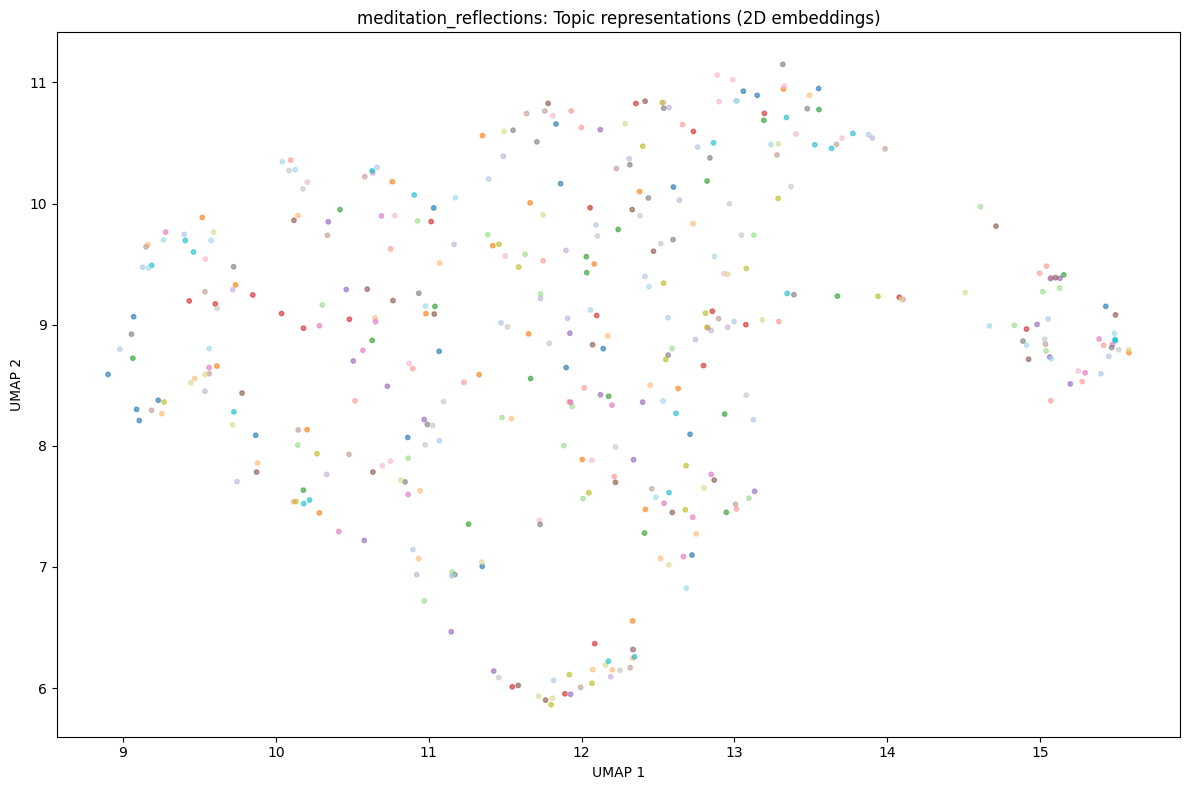

(datamapplot not installed; requires Python >= 3.9. Using matplotlib fallback.)


In [20]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

if datamapplot is not None:
    datamapplot.create_plot(
       reduced_embeddings,
       all_labels,
       label_font_size=15,
       title=f"{condition}: Topic representations with Llama 3",
       sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
       label_wrap_width=20,
       use_medoids=True
    )
else:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=range(len(all_labels)), cmap='tab20', s=10, alpha=0.6)
    plt.title(f"{condition}: Topic representations (2D embeddings)")
    plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
    plt.tight_layout(); plt.show()
    print("(datamapplot not installed; requires Python >= 3.9. Using matplotlib fallback.)")

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

In [ ]:
display(topic_model.visualize_hierarchy(custom_labels=True,color_threshold=.7))

### create and save final topic summary

In [ ]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(results_dir, f"topics_content/topic_content_{condition}_final.csv")
# summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
os.makedirs(os.path.dirname(summary_results_file), exist_ok=True)
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")



Final Topic Summary:
                                         Topic_Label  Topic_Number  \
0          Biscuit Preparation and Baking Techniques             0   
1                Baby Shower and Newborn Celebration             2   
2  Model Training and Deployment Optimization Tec...             1   
3                Exam Assessment and Grading Process             3   
4  Murano Glassmaking Techniques and Artisanal Pr...             4   
5                                            Outlier            -1   

   Sentence_Count  
0              39  
1              36  
2              36  
3              32  
4              26  
5              11  

Summary saved to c:\Users\andre\projects\MOSAIC\EVAL\trial\topics_content/topic_content_trial_final.csv
